# Discretization Classification 2.0(Template) - KFold
## Author: Ming

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.calibration import CalibratedClassifierCV

#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock


#Import Our Class
%run "TEJ Classification Package.ipynb"

## Import Data

In [2]:
# Load Data
data_name = "Tsai_Original"
# data_name = "Australian_Original"

if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()    
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData() 
    
# # Select Data
# data_list = tsaiData_data
# target_list = tsaiData_target
# discretize_coloumn = continuous_coloumn

# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values


# Declare Result List (Alogorithm, fold, ACC, AUC)
evaluation_result_list = []

In [3]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 6819
特徵數量(不含Target) :: 95


In [4]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts))

{0: 6599, 1: 220}

In [5]:
data_list[discretize_coloumn][5]

array([-1.48400000e+01, -2.11900000e+01, -1.75600000e+01, -4.04000000e+00,
       -3.93000000e+00, -1.75200000e+01, -3.44600000e+01, -4.11800000e+01,
       -1.69500000e+01, -3.52900000e+01,  1.35900000e+01,  0.00000000e+00,
        2.67100000e+01,  7.16000000e+00,  0.00000000e+00,  7.18000000e+00,
        7.18000000e+00,  7.18000000e+00, -4.23000000e+00,  2.22000000e+00,
        1.19700000e+01, -2.10000000e+00, -4.13000000e+00, -3.33260000e+02,
       -4.64900000e+01, -1.06630000e+02, -8.15400000e+01, -8.59700000e+01,
       -3.87000000e+00, -3.73200000e+01, -9.54000000e+00,  1.26900000e+01,
        4.87800000e+01,  1.38100000e+01, -1.25100000e+01,  1.57340000e+02,
        6.11400000e+01,  3.88600000e+01,  7.10000000e+01,  1.05610000e+02,
        6.29000000e+00, -2.09700000e+01, -4.12600000e+01,  5.04300000e+01,
        6.40000000e-01,  7.53000000e+00,  4.84500000e+01,  3.39000000e+00,
        1.23000000e+00,  1.29000000e+00,  7.25200000e+03, -1.27000000e+03,
        6.53125000e+03, -

## Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [6]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## KFoldFuntion

In [7]:
class KFoldFuntion:
    # linear_svc,'linear_svc','baseline', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, method, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.method = method  # (Baseline, MDLP, CAIM)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        #for train_index, test_index in kf.split(self.X,self.y):
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            if self.method == 'Baseline':
                
                # Convert to Dataframe
                X_train_dataframe = pd.DataFrame(X_train)
                X_test_dataframe  = pd.DataFrame(X_test)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe  = pd.DataFrame(y_test)
                predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
            else:

                # Declare Training Data Discretizer
                discretize_train = Discretization(X_train,y_train,self.discretize_coloumn)

                # Select Discretize Feature (Training Data Continous Feature)
                selectData_list, disSelectData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns

                
                
                # Discretize(Train)
                if self.method == 'MDLP':
                    selectDataDiscretiz_list = discretize_train.MDLP(selectData_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_list = discretize_train.CAIMD(selectData_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_SC(selectData_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_RG(selectData_list)
                # Merge dis_feature & categeorial_feature
                X_train_dis = discretize_train.MergeFeatures(selectDataDiscretiz_list,disSelectData_list)

                # Declare Testing Data Discretizer
                discretize_test = Discretization(X_test,y_test,discretize_coloumn)

                # Select Discretize Feature (Testing Data Continous Feature)
                selectData_test_list, disSelectData_test_list  = discretize_test.SelectFeatures()

                
                
                # Employ Training Data Cutpoint
                if self.method == 'MDLP':
                    selectDataDiscretiz_test_list = discretize_train.MDLP_transform(selectData_test_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_test_list = discretize_train.CAIMD_transform(selectData_test_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_SC_transform(selectData_test_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_RG_transform(selectData_test_list)
                    
                # Merge dis_feature & categeorial_feature
                X_test_dis = discretize_test.MergeFeatures(selectDataDiscretiz_test_list,disSelectData_test_list)

                # Convert to Dataframe
                X_train_dis_dataframe = pd.DataFrame(X_train_dis)
                X_test_dis_dataframe = pd.DataFrame(X_test_dis)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe = pd.DataFrame(y_test)

                # Prediction
                predictions,proba = self.Classification(X_train_dis_dataframe,y_train_dataframe,X_test_dis_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe[0].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{method}-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,method=self.method,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [8]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC):
    #Labels
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_SC')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    #autolabel(rects5)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [9]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [10]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

## Start Classify

## Run 10 Times


程式開始


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarn

Mean Accuracy: 0.9684704474991556
Mean Accuracy[0.9699413489736071, 0.967008797653959, 0.9699413489736071, 0.967008797653959, 0.9684519442406456]
Mean Auc: 0.8827871757455099
Mean Auc[0.8890455911361835, 0.8636427653469008, 0.9272925725753921, 0.8930155458984813, 0.8409394037705922]
Mean TypeII: 0.8467876089743896
Mean TypeII[0.8048780487804879, 0.9302325581395349, 0.813953488372093, 0.803921568627451, 0.8809523809523809]
Mean TypeI: 0.0043924720577678406
Mean TypeI[0.006046863189720333, 0.003785011355034065, 0.004542013626040878, 0.0030464584920030465, 0.004542013626040878]


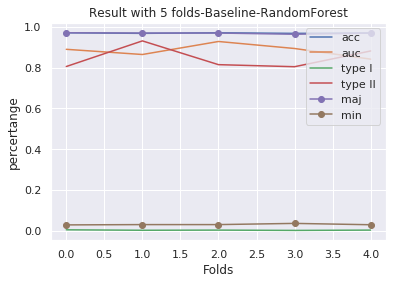

Mean : [0.96847045 0.88278718 0.00439247 0.84678761]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.9488199869616574
Mean Accuracy[0.9413489736070382, 0.9457478005865103, 0.9479472140762464, 0.9567448680351907, 0.9523110785033015]
Mean Auc: 0.6160621745501306
Mean Auc[0.6328767123287671, 0.6177912560020218, 0.5898735159463024, 0.662488034379519, 0.5772813540940429]
Mean TypeII: 0.7396826339683482
Mean TypeII[0.7, 0.7333333333333333, 0.7959183673469388, 0.6486486486486487, 0.8205128205128205]
Mean TypeI: 0.028193016931390473
Mean TypeI[0.03424657534246575, 0.0310841546626232, 0.024334600760456272, 0.02637528259231349, 0.024924471299093656]


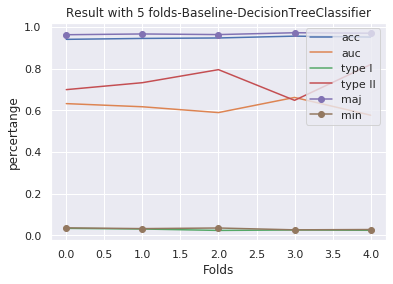

Mean : [0.94881999 0.61606217 0.02819302 0.73968263]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of 

Mean Accuracy: 0.9671502615198921
Mean Accuracy[0.9736070381231672, 0.9604105571847508, 0.968475073313783, 0.968475073313783, 0.9647835656639765]
Mean Auc: 0.7839292501875275
Mean Auc[0.7547272423025434, 0.7996356196705644, 0.8809048885511651, 0.8829116314199396, 0.6014668689934244]
Mean TypeII: 0.9368464052287582
Mean TypeII[0.9444444444444444, 0.9411764705882353, 0.8958333333333334, 0.925, 0.9777777777777777]
Mean TypeI: 0.0027284670508952785
Mean TypeI[0.0015060240963855422, 0.00456968773800457, 0.0, 0.004531722054380665, 0.0030349013657056147]


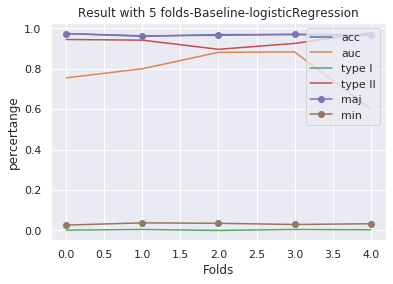

Mean : [0.96715026 0.78392925 0.00272847 0.93684641]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\calibration.py:455: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


Mean Accuracy: 0.970524631925006
Mean Accuracy[0.9648093841642229, 0.968475073313783, 0.9714076246334311, 0.9699413489736071, 0.9779897285399853]
Mean Auc: 0.9436813374784336
Mean Auc[0.9513426139737414, 0.9593092300587187, 0.9172692837465565, 0.9304805129313449, 0.9600050466818068]
Mean TypeII: 0.7123188405797102
Mean TypeII[0.8260869565217391, 0.6521739130434783, 0.75, 0.7619047619047619, 0.5714285714285714]
Mean TypeI: 0.006669203578536791
Mean TypeI[0.007587253414264037, 0.009863429438543247, 0.004545454545454545, 0.00680786686838124, 0.004542013626040878]


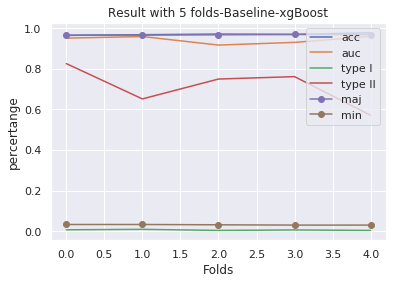

Mean : [0.97052463 0.94368134 0.0066692  0.71231884]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: Converge

Mean Accuracy: 0.9675911124115985
Mean Accuracy[0.969208211143695, 0.9648093841642229, 0.968475073313783, 0.9640762463343109, 0.971386647101981]
Mean Auc: 0.8436164834992376
Mean Auc[0.817592392478928, 0.83106952887538, 0.8750418111719451, 0.8521145340265384, 0.8422641509433962]
Mean TypeII: 0.9959183673469388
Mean TypeII[1.0, 1.0, 1.0, 0.9795918367346939, 1.0]
Mean TypeI: 0.0003030346509792668
Mean TypeI[0.0, 0.0, 0.0, 0.0007604562737642585, 0.0007547169811320754]


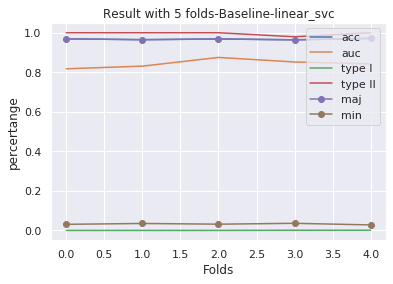

Mean : [9.67591112e-01 8.43616483e-01 3.03034651e-04 9.95918367e-01]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 

Mean Accuracy: 0.9389877641824249
Mean Accuracy[0.966275659824047, 0.9442815249266863, 0.9266862170087976, 0.9611436950146628, 0.896551724137931]
Mean Auc: 0.7650144067679165
Mean Auc[0.754117077890663, 0.7357065542254319, 0.786899936862258, 0.7709086676495692, 0.7774397972116603]
Mean TypeII: 0.6732415182643146
Mean TypeII[0.9743589743589743, 0.6382978723404256, 0.5405405405405406, 0.7755102040816326, 0.4375]
Mean TypeI: 0.04078271187623598
Mean TypeI[0.0060377358490566035, 0.03492786636294609, 0.06028636021100226, 0.011406844106463879, 0.09125475285171103]


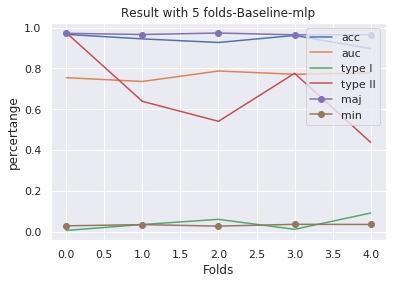

Mean : [0.93898776 0.76501441 0.04078271 0.67324152]
Mean Accuracy: 0.967736879360906
Mean Accuracy[0.9787390029325513, 0.9582111436950147, 0.9626099706744868, 0.9736070381231672, 0.9655172413793104]
Mean Auc: 0.5
Mean Auc[0.5, 0.5, 0.5, 0.5, 0.5]
Mean TypeII: 1.0
Mean TypeII[1.0, 1.0, 1.0, 1.0, 1.0]
Mean TypeI: 0.0
Mean TypeI[0.0, 0.0, 0.0, 0.0, 0.0]


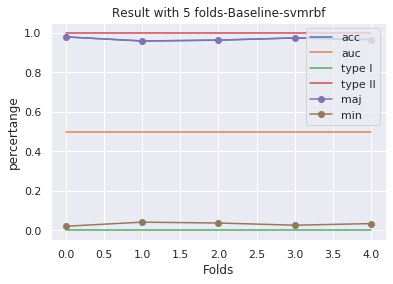

Mean : [0.96773688 0.5        0.         1.        ]
Mean Accuracy: 0.968763595054036
Mean Accuracy[0.9611436950146628, 0.9699413489736071, 0.9736070381231672, 0.9714076246334311, 0.9677182685253118]
Mean Auc: 0.8559355258129135
Mean Auc[0.8116906983319198, 0.8836168597230973, 0.9166276298906291, 0.771988388969521, 0.895754052149401]
Mean TypeII: 0.8060523813121536
Mean TypeII[0.8148148148148148, 0.8085106382978723, 0.7027027027027027, 0.8205128205128205, 0.8837209302325582]
Mean TypeI: 0.0053024803550812336
Mean TypeI[0.006870229007633588, 0.002277904328018223, 0.007535795026375283, 0.005283018867924529, 0.004545454545454545]


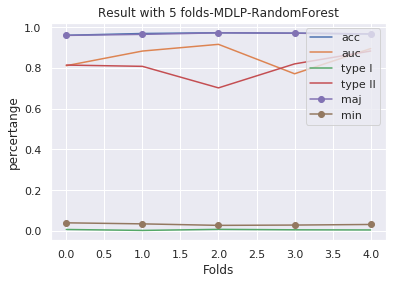

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.9530714333355567
Mean Accuracy[0.9479472140762464, 0.9574780058651027, 0.9574780058651027, 0.9552785923753666, 0.9471753484959647]
Mean Auc: 0.6238655820105892
Mean Auc[0.648816636920928, 0.59992994487768, 0.642310483604935, 0.5807930459633245, 0.6474777986860785]
Mean TypeII: 0.7278623767417332
Mean TypeII[0.673469387755102, 0.7804878048780488, 0.6956521739130435, 0.8157894736842105, 0.6739130434782609]
Mean TypeI: 0.02440645923708841
Mean TypeI[0.028897338403041824, 0.019652305366591082, 0.019726858877086494, 0.02262443438914027, 0.031131359149582385]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


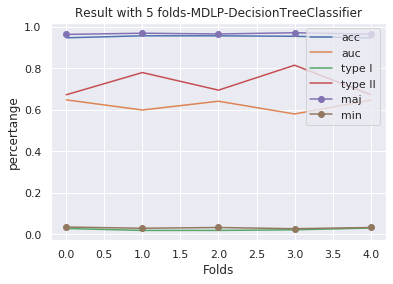

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.9678850130060696
Mean Accuracy[0.9655425219941349, 0.9728739002932552, 0.9655425219941349, 0.9596774193548387, 0.9757887013939839]
Mean Auc: 0.9309732055798378
Mean Auc[0.9503194626474444, 0.9328499562109208, 0.9213159167876149, 0.920944118229201, 0.9294365740240078]
Mean TypeII: 0.7383158361419231
Mean TypeII[0.75, 0.7567567567567568, 0.717948717948718, 0.8478260869565217, 0.6190476190476191]
Mean TypeI: 0.00847661789890726
Mean TypeI[0.00382262996941896, 0.006782215523737754, 0.014339622641509434, 0.012139605462822459, 0.005299015897047691]


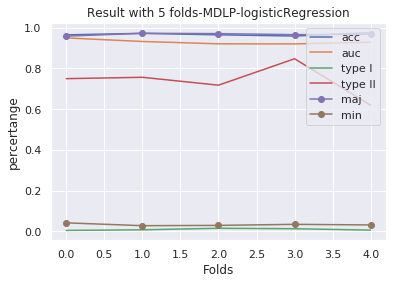

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.9696443286436895
Mean Accuracy[0.9604105571847508, 0.9750733137829912, 0.9655425219941349, 0.9728739002932552, 0.9743213499633162]
Mean Auc: 0.9363792448676046
Mean Auc[0.8929774191045239, 0.957194000967586, 0.9461212584207236, 0.9464315595716198, 0.9391719862735692]
Mean TypeII: 0.72239318946636
Mean TypeII[0.8571428571428571, 0.6923076923076923, 0.6363636363636364, 0.6944444444444444, 0.7317073170731707]
Mean TypeI: 0.007278818055314207
Mean TypeI[0.009125475285171103, 0.005283018867924529, 0.009167303284950344, 0.009036144578313253, 0.0037821482602118004]


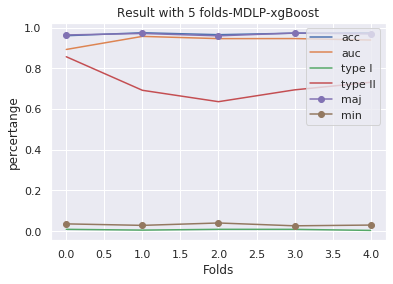

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochasti

Mean Accuracy: 0.9696443286436895
Mean Accuracy[0.9736070381231672, 0.9655425219941349, 0.9640762463343109, 0.9706744868035191, 0.9743213499633162]
Mean Auc: 0.9259656292833001
Mean Auc[0.9040518911633392, 0.9197260273972603, 0.9263443780554046, 0.9644680313368713, 0.9152378184636251]
Mean TypeII: 0.8690585911784069
Mean TypeII[0.7777777777777778, 0.9, 0.8775510204081632, 0.8222222222222222, 0.967741935483871]
Mean TypeI: 0.002574232373290015
Mean TypeI[0.000758150113722517, 0.0015220700152207, 0.0045627376425855515, 0.002274450341167551, 0.0037537537537537537]


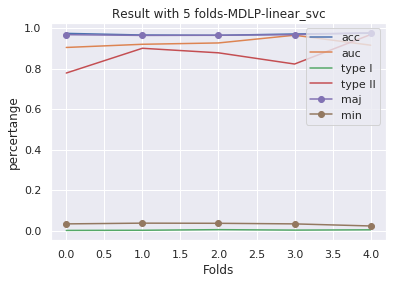

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.9681774075213594
Mean Accuracy[0.967008797653959, 0.966275659824047, 0.9714076246334311, 0.966275659824047, 0.9699192956713133]
Mean Auc: 0.8006807651217243
Mean Auc[0.8774823513887973, 0.8485605649103748, 0.7278121775025799, 0.7108677038401265, 0.8386810279667423]
Mean TypeII: 0.9112517351261065
Mean TypeII[0.9782608695652174, 0.9183673469387755, 0.8947368421052632, 0.9148936170212766, 0.85]
Mean TypeI: 0.002420020991528897
Mean TypeI[0.0, 0.0007604562737642585, 0.003770739064856712, 0.002277904328018223, 0.005291005291005291]


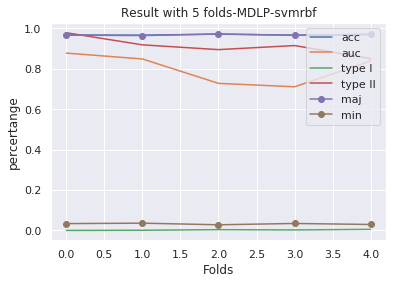

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.9659774561462016
Mean Accuracy[0.9750733137829912, 0.9648093841642229, 0.966275659824047, 0.9574780058651027, 0.9662509170946442]
Mean Auc: 0.8987069384607395
Mean Auc[0.940177376171352, 0.8573866793681035, 0.8776390904692791, 0.8940769013288098, 0.9242546449661531]
Mean TypeII: 0.7035254642007372
Mean TypeII[0.6666666666666666, 0.7105263157894737, 0.7948717948717948, 0.6851851851851852, 0.660377358490566]
Mean TypeI: 0.011823092037467512
Mean TypeI[0.007530120481927711, 0.01583710407239819, 0.011320754716981131, 0.01603053435114504, 0.008396946564885497]


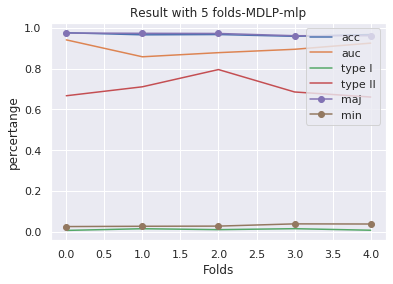

Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Mean Accuracy: 0.9689103301971027
Mean Accuracy[0.9648093841642229, 0.967008797653959, 0.9728739002932552, 0.9714076246334311, 0.9684519442406456]
Mean Auc: 0.9311372994286293
Mean Auc[0.8977931792112959, 0.9186673405778789, 0.9410885382897485, 0.9709207311936652, 0.9272167078705582]
Mean TypeII: 0.7414863139512853
Mean TypeII[0.7021276595744681, 0.8444444444444444, 0.7380952380952381, 0.6666666666666666, 0.7560975609756098]
Mean TypeI: 0.007427131439282773
Mean TypeI[0.011389521640091117, 0.00530705079605762, 0.0045385779122541605, 0.006823351023502654, 0.009077155824508321]


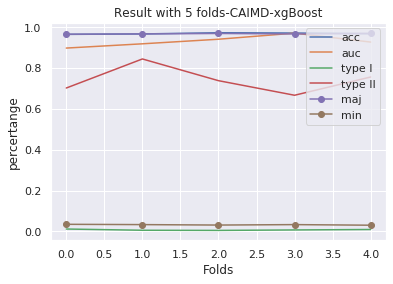

Mean Accuracy: 0.9552726756357268
Mean Accuracy[0.9508797653958945, 0.9472140762463344, 0.9640762463343109, 0.9545454545454546, 0.9596478356566398]
Mean Auc: 0.6497996856404218
Mean Auc[0.6375570776255708, 0.6154455730855125, 0.6813089835026296, 0.65750419408956, 0.6571825998988365]
Mean TypeII: 0.6764692218350754
Mean TypeII[0.7, 0.7380952380952381, 0.6190476190476191, 0.6585365853658537, 0.6666666666666666]
Mean TypeI: 0.02363755559298576
Mean TypeI[0.0243531202435312, 0.031013615733736764, 0.01739788199697428, 0.026455026455026454, 0.01896813353566009]


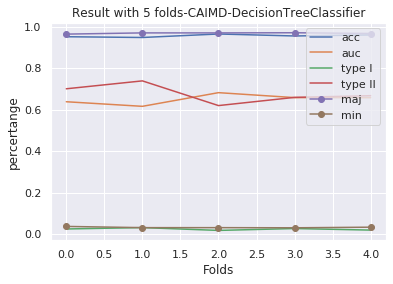

Mean Accuracy: 0.9680303496470396
Mean Accuracy[0.9618768328445748, 0.9721407624633431, 0.9699413489736071, 0.969208211143695, 0.966984592809978]
Mean Auc: 0.8387767934129144
Mean Auc[0.8460489115069267, 0.8338587467507328, 0.910145590901889, 0.7755517186631737, 0.8282789992418499]
Mean TypeII: 0.8570310080534875
Mean TypeII[0.8888888888888888, 0.7804878048780488, 0.8837209302325582, 0.868421052631579, 0.8636363636363636]
Mean TypeI: 0.004390794086522842
Mean TypeI[0.0030534351145038168, 0.0045351473922902496, 0.002271006813020439, 0.006787330316742082, 0.00530705079605762]


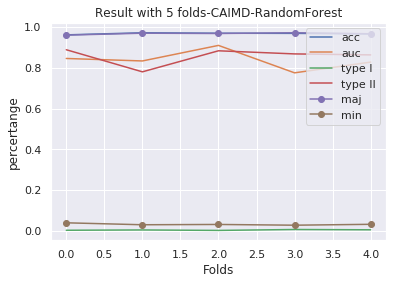

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.9677374172463278
Mean Accuracy[0.9648093841642229, 0.9655425219941349, 0.9728739002932552, 0.966275659824047, 0.9691856199559794]
Mean Auc: 0.8249709200494655
Mean Auc[0.7776326621073961, 0.8063942874682952, 0.8318944986901643, 0.840426248841715, 0.868506903139757]
Mean TypeII: 0.9947368421052631
Mean TypeII[1.0, 1.0, 0.9736842105263158, 1.0, 1.0]
Mean TypeI: 0.00015163002274450342
Mean TypeI[0.0, 0.0, 0.0, 0.000758150113722517, 0.0]


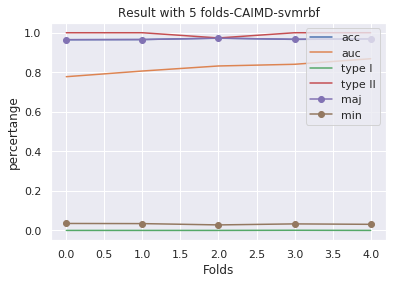

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.9658309361573035
Mean Accuracy[0.9574780058651027, 0.968475073313783, 0.9750733137829912, 0.9611436950146628, 0.966984592809978]
Mean Auc: 0.9010550634872597
Mean Auc[0.9210013637249171, 0.9266365688487584, 0.8514742628685656, 0.9277362125352807, 0.878426909458776]
Mean TypeII: 0.815167513333017
Mean TypeII[0.8135593220338984, 0.7714285714285715, 0.8333333333333334, 0.9019607843137255, 0.7555555555555555]
Mean TypeI: 0.00802517404313505
Mean TypeI[0.007662835249042145, 0.012039127163280662, 0.006746626686656672, 0.005331302361005331, 0.00834597875569044]


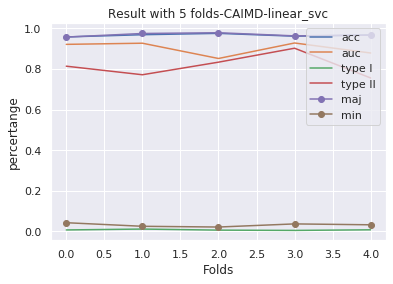

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.9631916399696203
Mean Accuracy[0.967008797653959, 0.9618768328445748, 0.9574780058651027, 0.9626099706744868, 0.966984592809978]
Mean Auc: 0.9120241033254072
Mean Auc[0.8916011748829087, 0.9025667658398325, 0.910453774385072, 0.931215564738292, 0.9242832367809306]
Mean TypeII: 0.7330776543735913
Mean TypeII[0.7631578947368421, 0.6511627906976745, 0.8148148148148148, 0.7045454545454546, 0.7317073170731707]
Mean TypeI: 0.013483880468923782
Mean TypeI[0.012066365007541479, 0.018168054504163512, 0.010687022900763359, 0.015151515151515152, 0.0113464447806354]


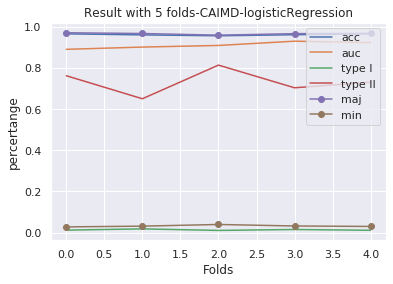

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.9586459702699969
Mean Accuracy[0.9640762463343109, 0.9494134897360704, 0.9538123167155426, 0.9604105571847508, 0.9655172413793104]
Mean Auc: 0.8457363206845561
Mean Auc[0.8435837765957447, 0.8404097011144883, 0.8249765867012463, 0.8438423024277789, 0.8758692365835222]
Mean TypeII: 0.6736904761904763
Mean TypeII[0.6041666666666666, 0.7083333333333334, 0.6666666666666666, 0.7142857142857143, 0.675]
Mean TypeI: 0.020307964102941774
Mean TypeI[0.015197568389057751, 0.026595744680851064, 0.0264750378214826, 0.018154311649016642, 0.015117157974300832]


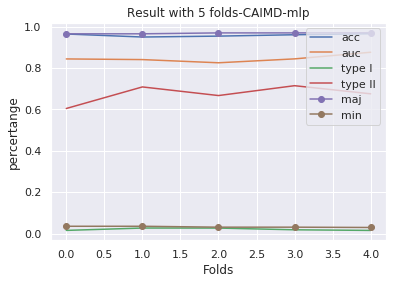

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaco

Mean Accuracy: 0.950283142886035
Mean Accuracy[0.9611436950146628, 0.9318181818181818, 0.9589442815249267, 0.968475073313783, 0.9310344827586207]
Mean Auc: 0.6179210374550749
Mean Auc[0.47333559508231154, 0.7484138972809669, 0.764280253385758, 0.7412428129146396, 0.3623326286116984]
Mean TypeII: 0.9400724119435008
Mean TypeII[0.9787234042553191, 0.875, 0.9642857142857143, 0.8823529411764706, 1.0]
Mean TypeI: 0.01981232166774915
Mean TypeI[0.005315110098709187, 0.04380664652567976, 0.0015290519877675841, 0.009774436090225564, 0.038636363636363635]


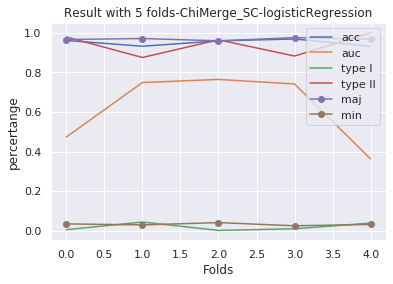

Compare Result-Tsai_Original-logisticRegression


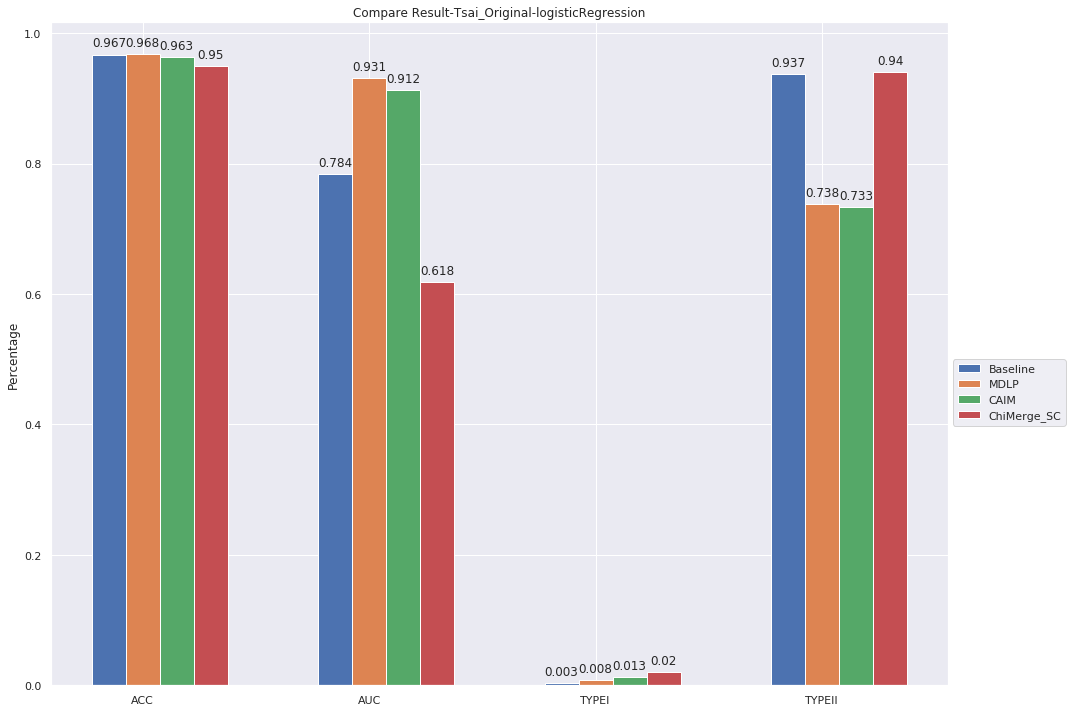

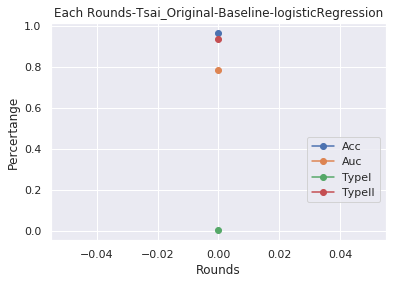

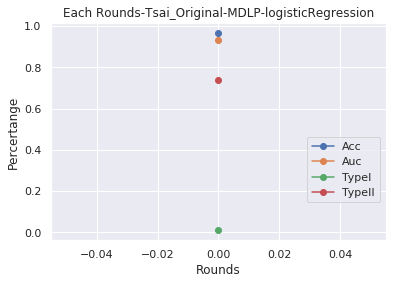

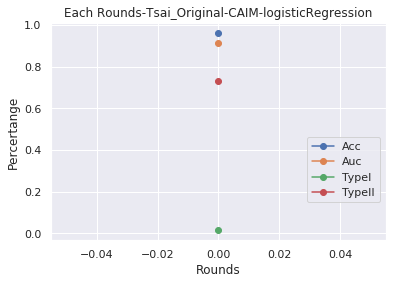

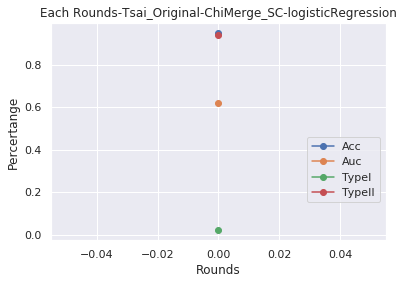

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.97 0.78   0.00    0.94          7.66
MDLP          0.97 0.93   0.01    0.74        189.45
CAIM          0.96 0.91   0.01    0.73       4602.98
ChiMerge      0.95 0.62   0.02    0.94      17136.15
Mean Accuracy: 0.9621622348493813
Mean Accuracy[0.9655425219941349, 0.9640762463343109, 0.9736070381231672, 0.9611436950146628, 0.946441672780631]
Mean Auc: 0.49957041237438027
Mean Auc[0.24603773584905658, 0.28722714501837043, 0.7837837837837838, 0.8818490245971162, 0.29895437262357416]
Mean TypeII: 0.9677250052250053
Mean TypeII[0.9743589743589743, 0.9761904761904762, 0.9459459459459459, 0.9629629629629629, 0.9791666666666666]
Mean TypeI: 0.006826538289132353
Mean TypeI[0.006792452830188679, 0.006051437216338881, 0.0007535795026375283, 0.0007633587786259542, 0.01977186311787072]


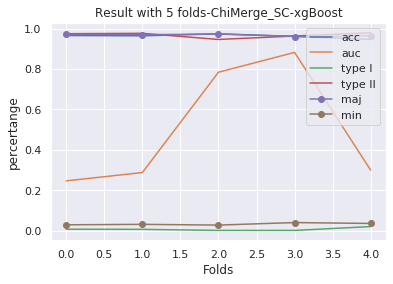

Compare Result-Tsai_Original-xgBoost


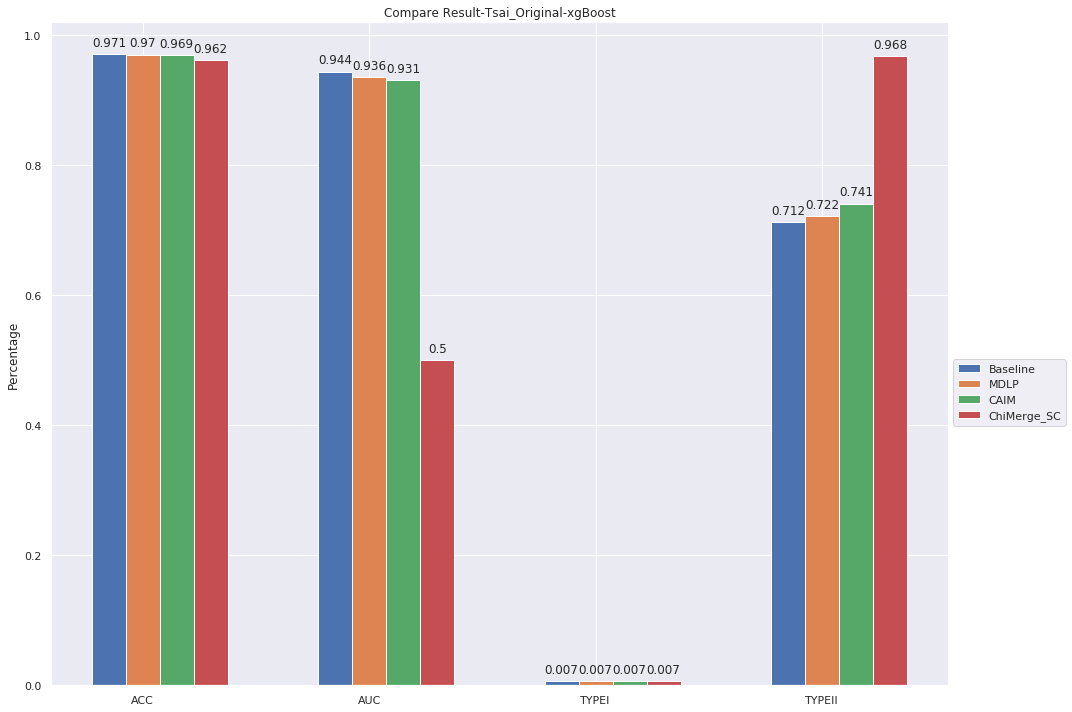

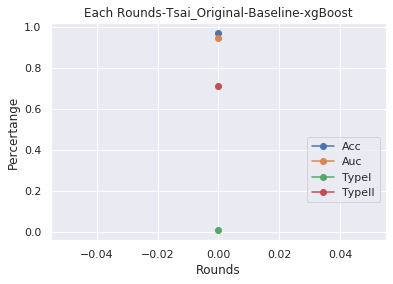

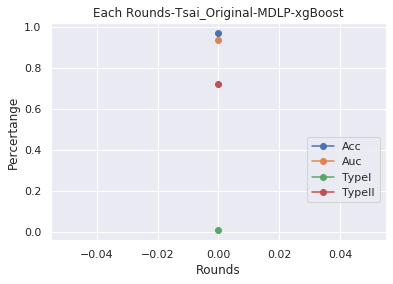

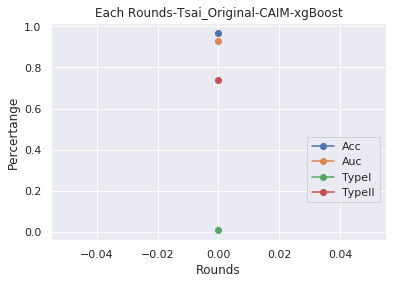

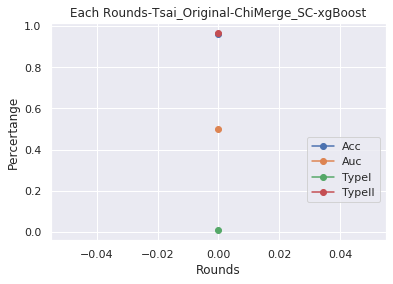

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.97 0.94   0.01    0.71         17.43
MDLP          0.97 0.94   0.01    0.72        192.18
CAIM          0.97 0.93   0.01    0.74       4519.43
ChiMerge      0.96 0.50   0.01    0.97      17423.44
Mean Accuracy: 0.955859401053825
Mean Accuracy[0.9626099706744868, 0.9560117302052786, 0.9648093841642229, 0.9347507331378299, 0.9611151870873074]
Mean Auc: 0.6265501538259628
Mean Auc[0.7489238980716253, 0.6881678784571238, 0.6752130898021308, 0.2686997991967871, 0.7517461036021469]
Mean TypeII: 0.9608408078808871
Mean TypeII[0.9545454545454546, 0.9534883720930233, 0.96, 1.0, 0.9361702127659575]
Mean TypeI: 0.013589953859320821
Mean TypeI[0.006818181818181818, 0.014383043149129448, 0.0, 0.039909638554216864, 0.006838905775075988]


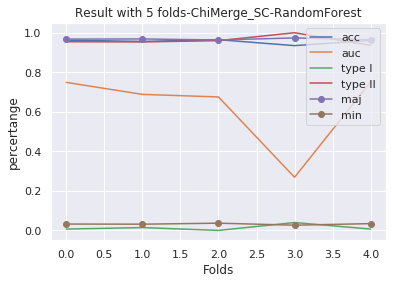

Compare Result-Tsai_Original-RandomForest


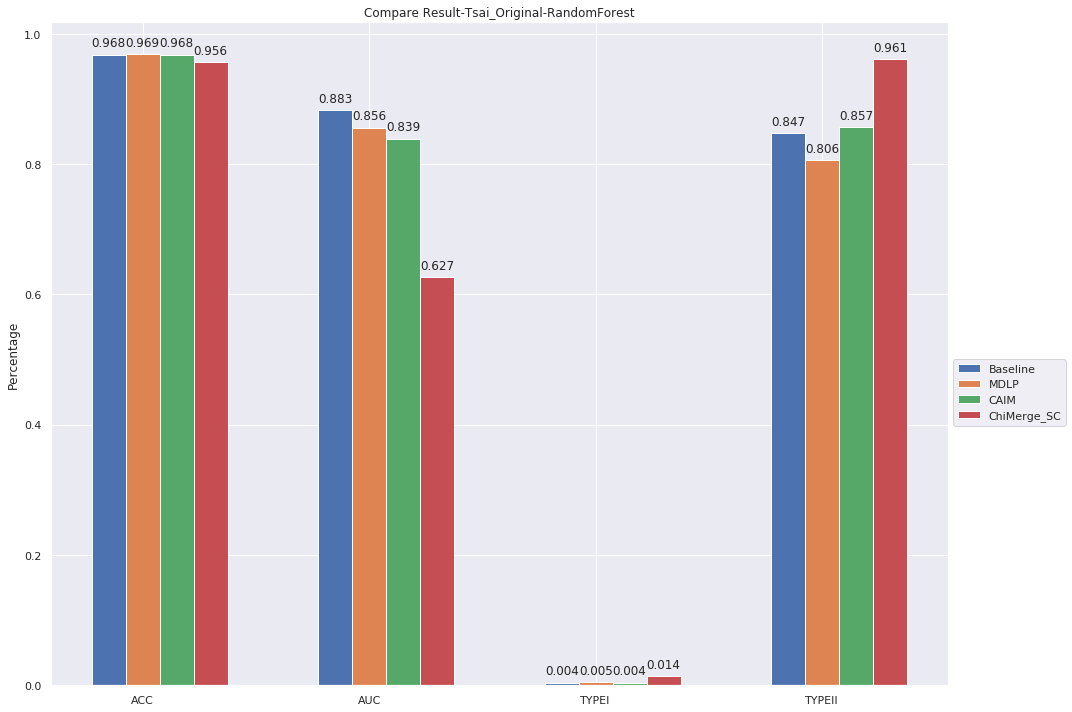

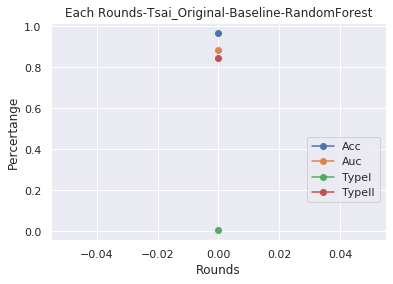

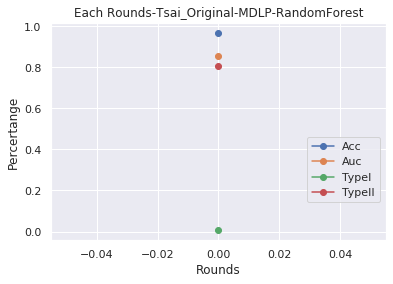

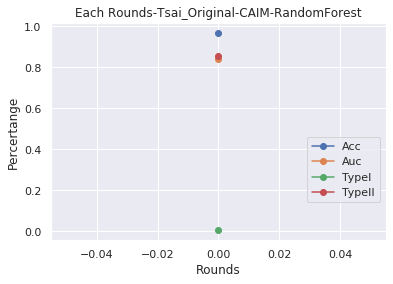

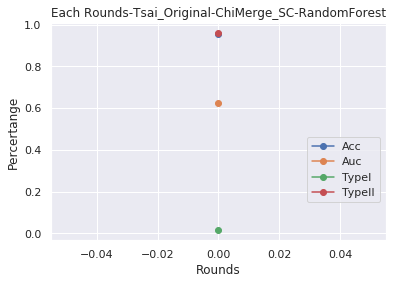

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.97 0.88   0.00    0.85          2.38
MDLP          0.97 0.86   0.01    0.81        184.52
CAIM          0.97 0.84   0.00    0.86       4582.58
ChiMerge      0.96 0.63   0.01    0.96      17541.75


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.9604033495200988
Mean Accuracy[0.966275659824047, 0.9618768328445748, 0.966275659824047, 0.9567448680351907, 0.9508437270726339]
Mean Auc: 0.6289482718060697
Mean Auc[0.653516143299425, 0.5822392293989576, 0.6924032850659175, 0.7316897658420045, 0.4848929354240432]
Mean TypeII: 0.9119900363755018
Mean TypeII[0.9117647058823529, 0.8478260869565217, 0.9047619047619048, 0.9622641509433962, 0.9333333333333333]
Mean TypeI: 0.010452681546226566
Mean TypeI[0.011278195488721804, 0.009863429438543247, 0.006051437216338881, 0.006102212051868803, 0.01896813353566009]


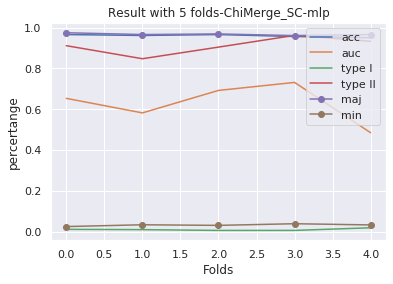

Compare Result-Tsai_Original-mlp


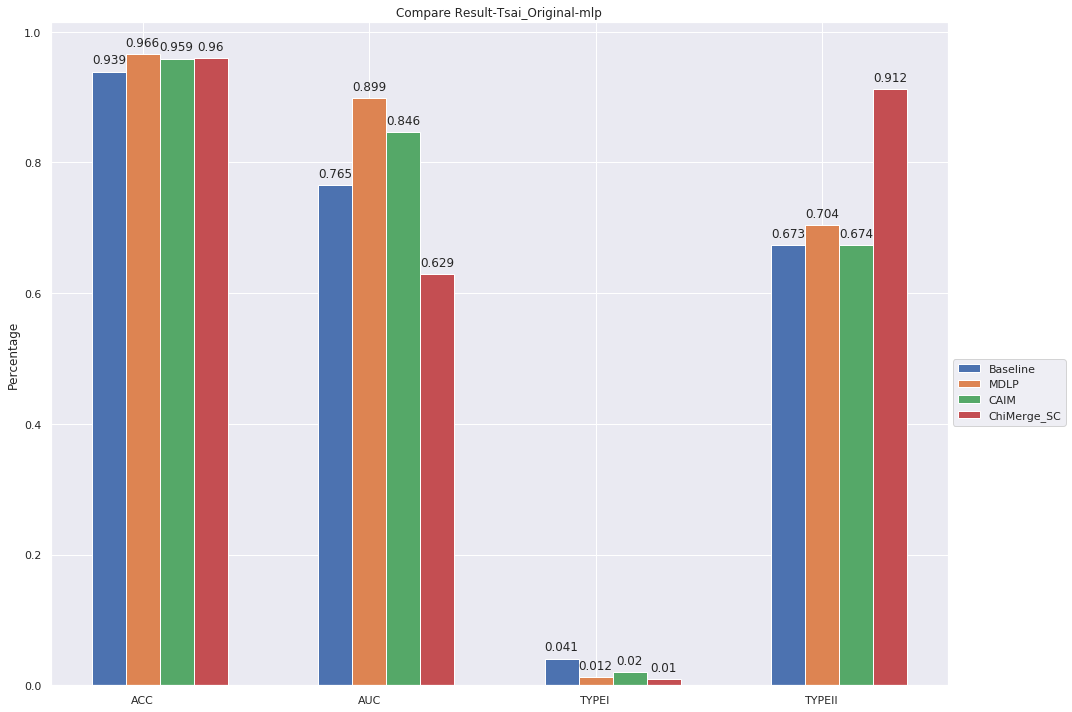

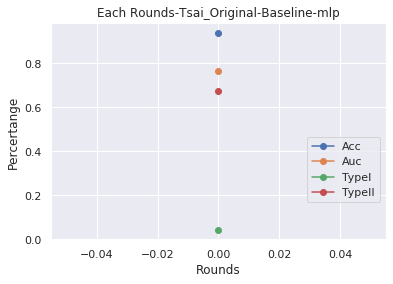

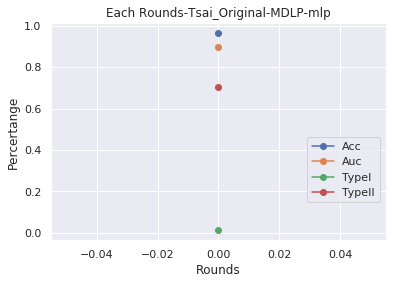

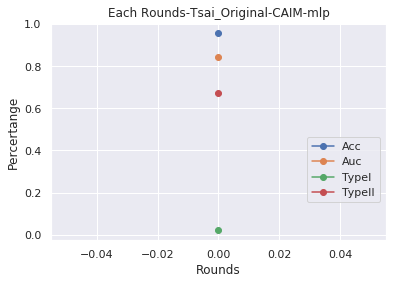

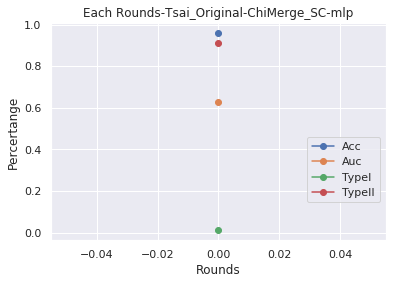

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.94 0.77   0.04    0.67        172.52
MDLP          0.97 0.90   0.01    0.70        222.89
CAIM          0.96 0.85   0.02    0.67       4920.86
ChiMerge      0.96 0.63   0.01    0.91      17165.77
Mean Accuracy: 0.9674434090747726
Mean Accuracy[0.967741935483871, 0.967008797653959, 0.966275659824047, 0.9721407624633431, 0.9640498899486427]
Mean Auc: 0.6508168030479984
Mean Auc[0.7652789221150584, 0.5704019883293712, 0.7603533434650456, 0.6579705471353327, 0.5000792141951838]
Mean TypeII: 0.9747340425531915
Mean TypeII[0.9361702127659575, 1.0, 0.9583333333333334, 1.0, 0.9791666666666666]
Mean TypeI: 0.0012095075693541444
Mean TypeI[0.0, 0.0022692889561270802, 0.0, 0.002257336343115124, 0.001520912547528517]


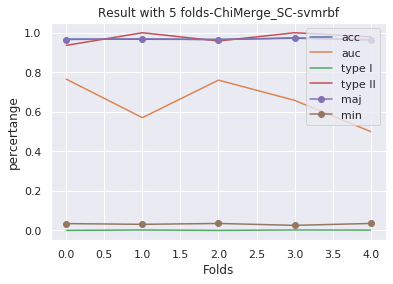

Compare Result-Tsai_Original-svmrbf


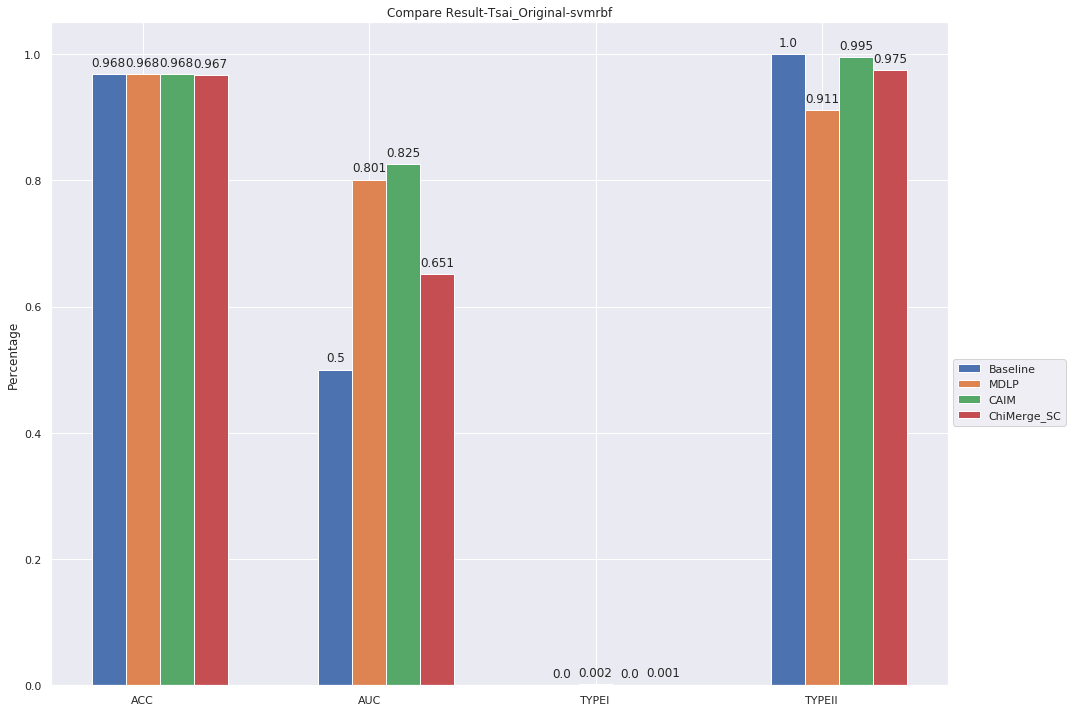

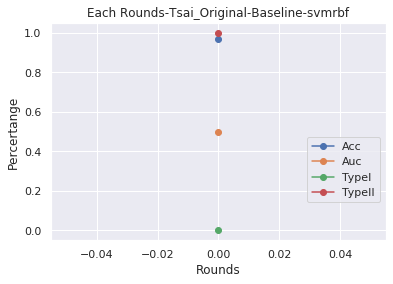

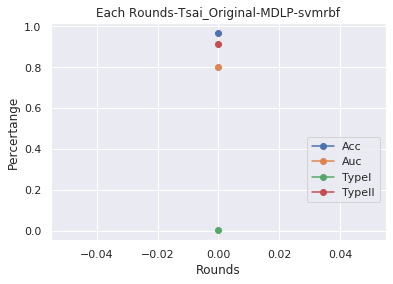

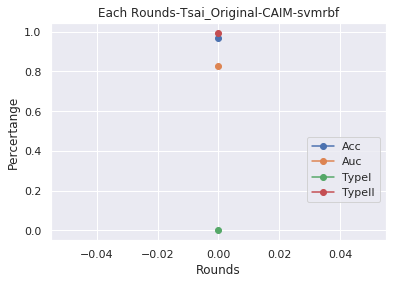

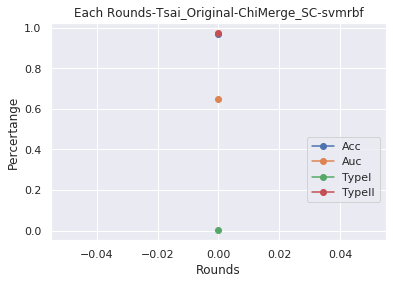

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.97 0.50   0.00    1.00        175.05
MDLP          0.97 0.80   0.00    0.91        140.65
CAIM          0.97 0.82   0.00    0.99       4477.09
ChiMerge      0.97 0.65   0.00    0.97      17696.07
Mean Accuracy: 0.8005442324697762
Mean Accuracy[0.8394428152492669, 0.7917888563049853, 0.7529325513196481, 0.906891495601173, 0.7116654438738078]
Mean Auc: 0.5563779358029739
Mean Auc[0.5316207063376874, 0.6363370147255689, 0.5751718869365928, 0.6161344593257241, 0.4226256116892963]
Mean TypeII: 0.7045694402216142
Mean TypeII[0.7948717948717948, 0.5277777777777778, 0.6181818181818182, 0.6956521739130435, 0.8863636363636364]
Mean TypeI: 0.18267468817243804
Mean TypeI[0.1418867924528302, 0.19954819277108435, 0.23147440794499619, 0.07207890743550835, 0.26838514025777105]


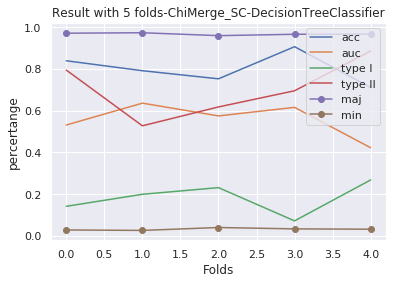

Compare Result-Tsai_Original-DecisionTreeClassifier


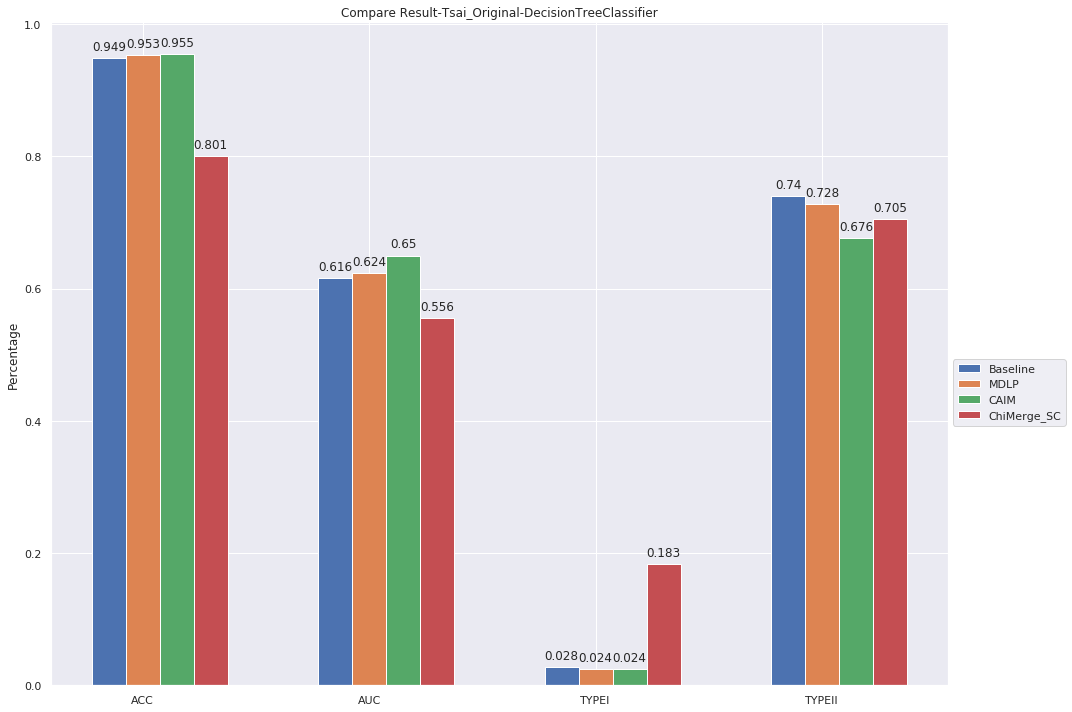

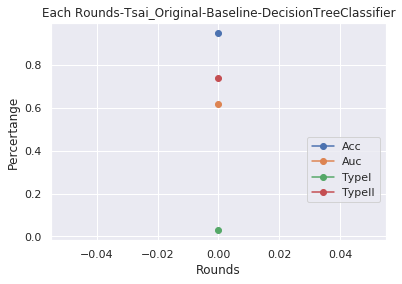

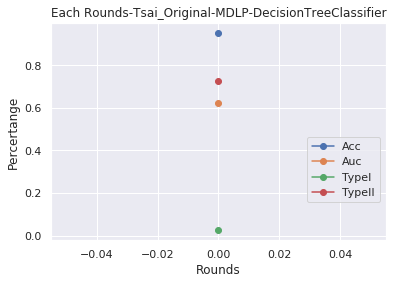

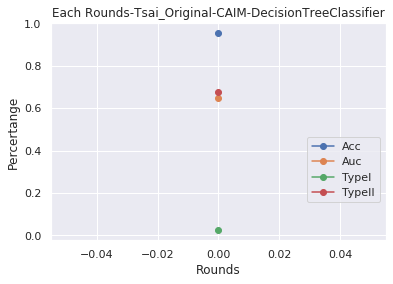

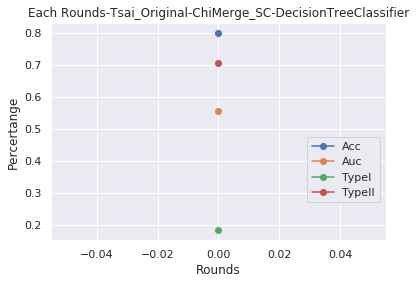

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.95 0.62   0.03    0.74          4.44
MDLP          0.95 0.62   0.02    0.73        189.30
CAIM          0.96 0.65   0.02    0.68       4560.00
ChiMerge      0.80 0.56   0.18    0.70      17805.44


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.9590852075054379
Mean Accuracy[0.9604105571847508, 0.9655425219941349, 0.9384164222873901, 0.9699413489736071, 0.9611151870873074]
Mean Auc: 0.5517671946507561
Mean Auc[0.5789473684210527, 0.624113475177305, 0.2686272988282766, 0.5442545581918404, 0.742893272635306]
Mean TypeII: 0.9543032377692198
Mean TypeII[0.9736842105263158, 1.0, 1.0, 0.975609756097561, 0.8222222222222222]
Mean TypeI: 0.010466389152759874
Mean TypeI[0.01282051282051282, 0.0, 0.026615969581749048, 0.0007558578987150416, 0.012139605462822459]


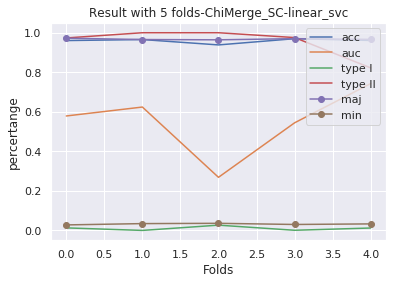

Compare Result-Tsai_Original-linear_svc


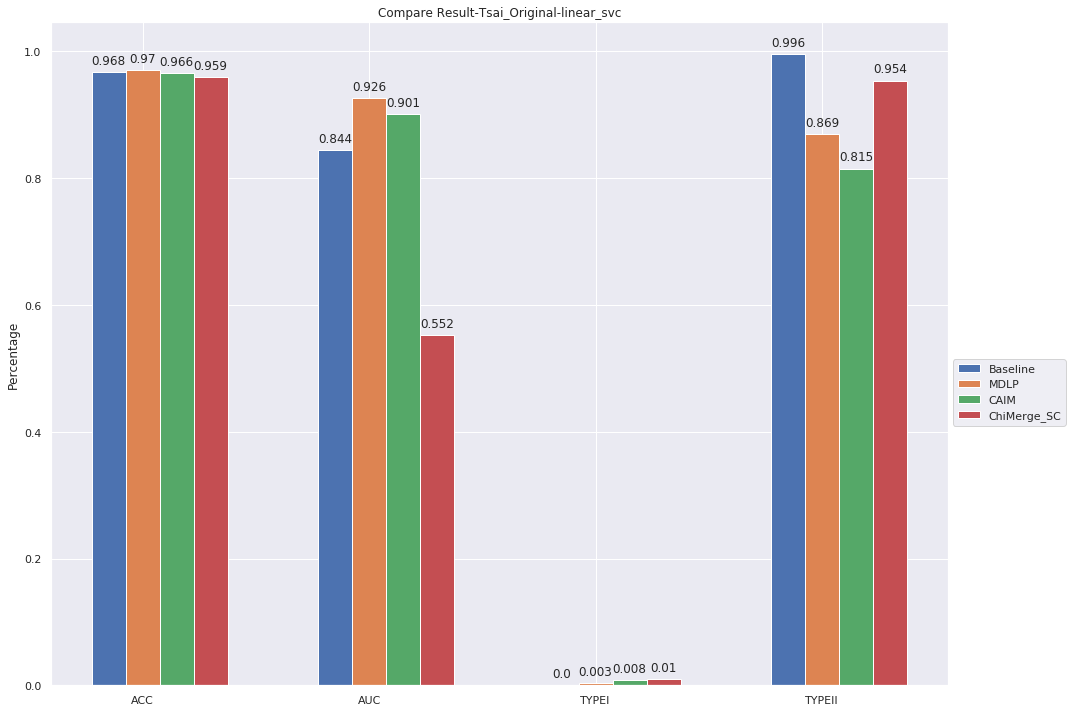

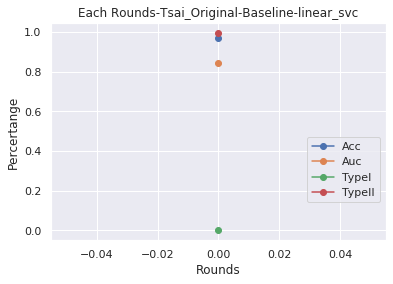

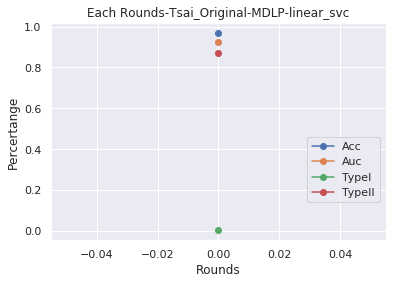

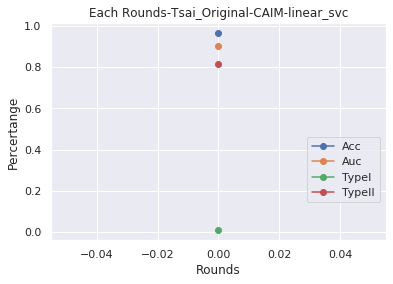

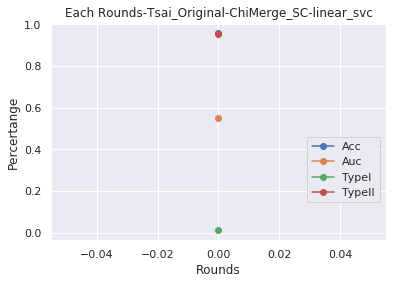

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.97 0.84   0.00    1.00        107.93
MDLP          0.97 0.93   0.00    0.87        175.19
CAIM          0.97 0.90   0.01    0.82       4516.27
ChiMerge      0.96 0.55   0.01    0.95      17794.27


In [ ]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

#DecisionTreeClassifier,logisticRegression,mlp,xgBoost
# classifier_list = [svmrbf,DecisionTreeClassifier,RandomForest,logisticRegression,mlp,xgBoost ]
# classifier_name_list = ['svmrbf','DecisionTreeClassifier','RandomForest','LogisticRegression','MLPClassifier','xgBoost' ]
def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
        
    classifier_result_list = []



    for idx,classifi in enumerate(classifier_list):

        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            runnung_time_list = []
            #Method Select

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'Baseline', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0)))
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIMD', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_SC', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_SC",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP','CAIM','ChiMerge'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{method}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,method=clf_name)
        pd.DataFrame(result_with_method).to_excel(file_name)
        
        
        # Thread Unlock
        lock.release()
    
lock = Lock()

t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
t6 = Thread(target=run10times,args=(mlp,"mlp"))
t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))

thread_list = [t0,t1,t2,t3,t4,t5,t6,t7]
#thread_list = [t3,t4,t5,t7]

#程式開始
for item in thread_list:
    item.start()
print("\n程式開始")


#程式結束
for item in thread_list:
    item.join()
print("\n程式結束")
    


#############################################################################YEE

## Record Result

title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
with pd.ExcelWriter('output.xlsx') as writer:  # doctest: +SKIP
        df1.to_excel(writer, sheet_name='Sheet_name_1')
        df2.to_excel(writer, sheet_name='Sheet_name_2')

file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
file_name = "result_10times_baseline_{file_timeA}.xlsx".format(file_timeA = file_time)
pd.DataFrame(result_10times_baseline).to_excel(file_name, header=False, index=False)

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))

In [ ]:

#ResultEachMethodLineChart(result_10times_ChiMerge_RG,"ChiMerge_RG",data_name,clf_name)